# Exploring the MPQA, NOREC, and OPENER_EN datasets

This notebook explores the MPQA, NOREC, and OPENER_EN datasets to help explain
the obtained results and to select responses in the exploitation approach in
experiment 2.

First relevant modules are imported, and the test datasets are loaded:

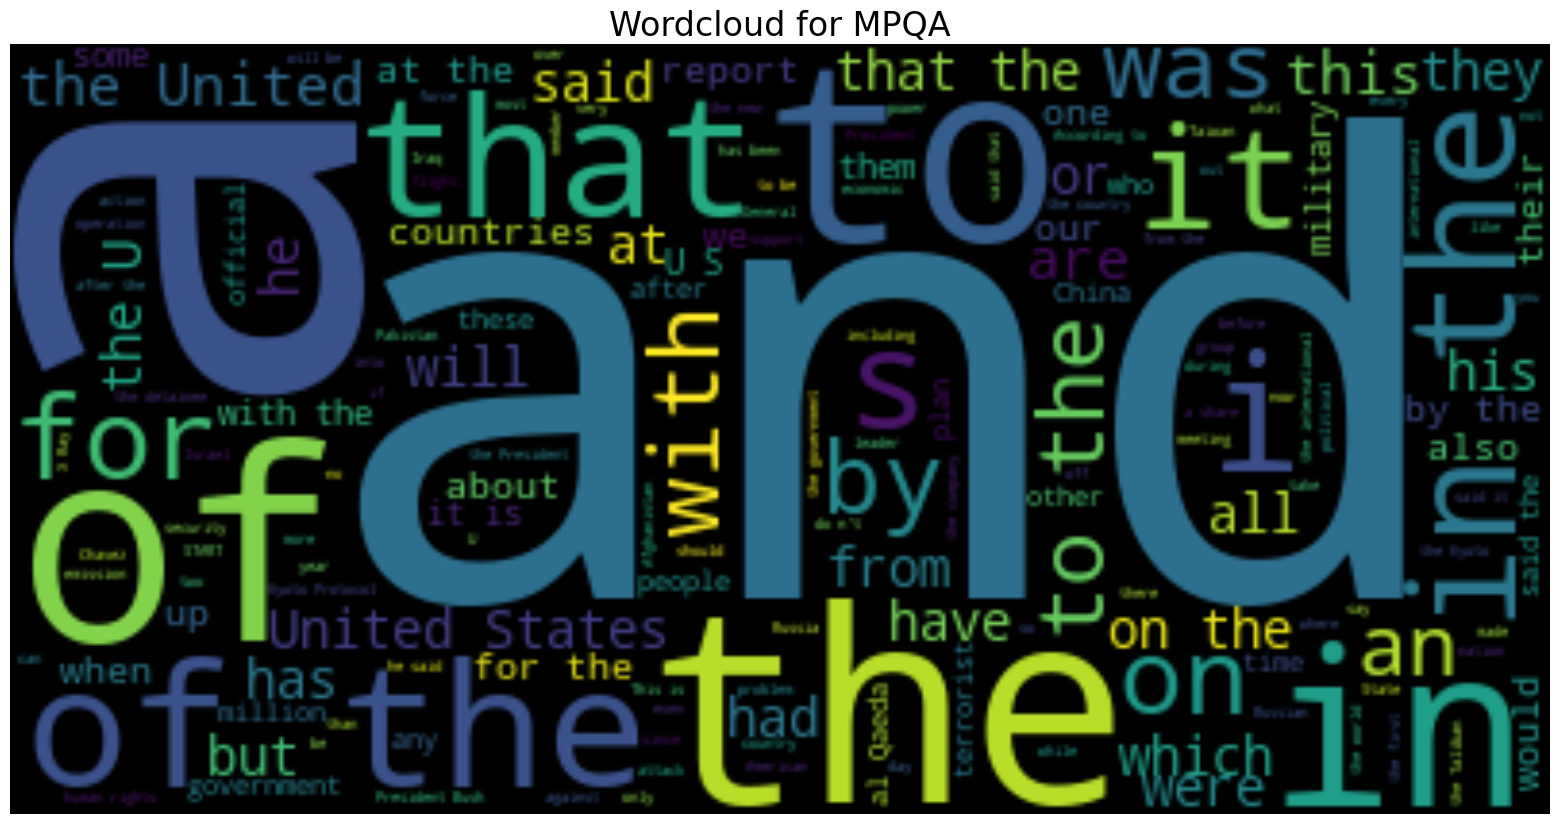

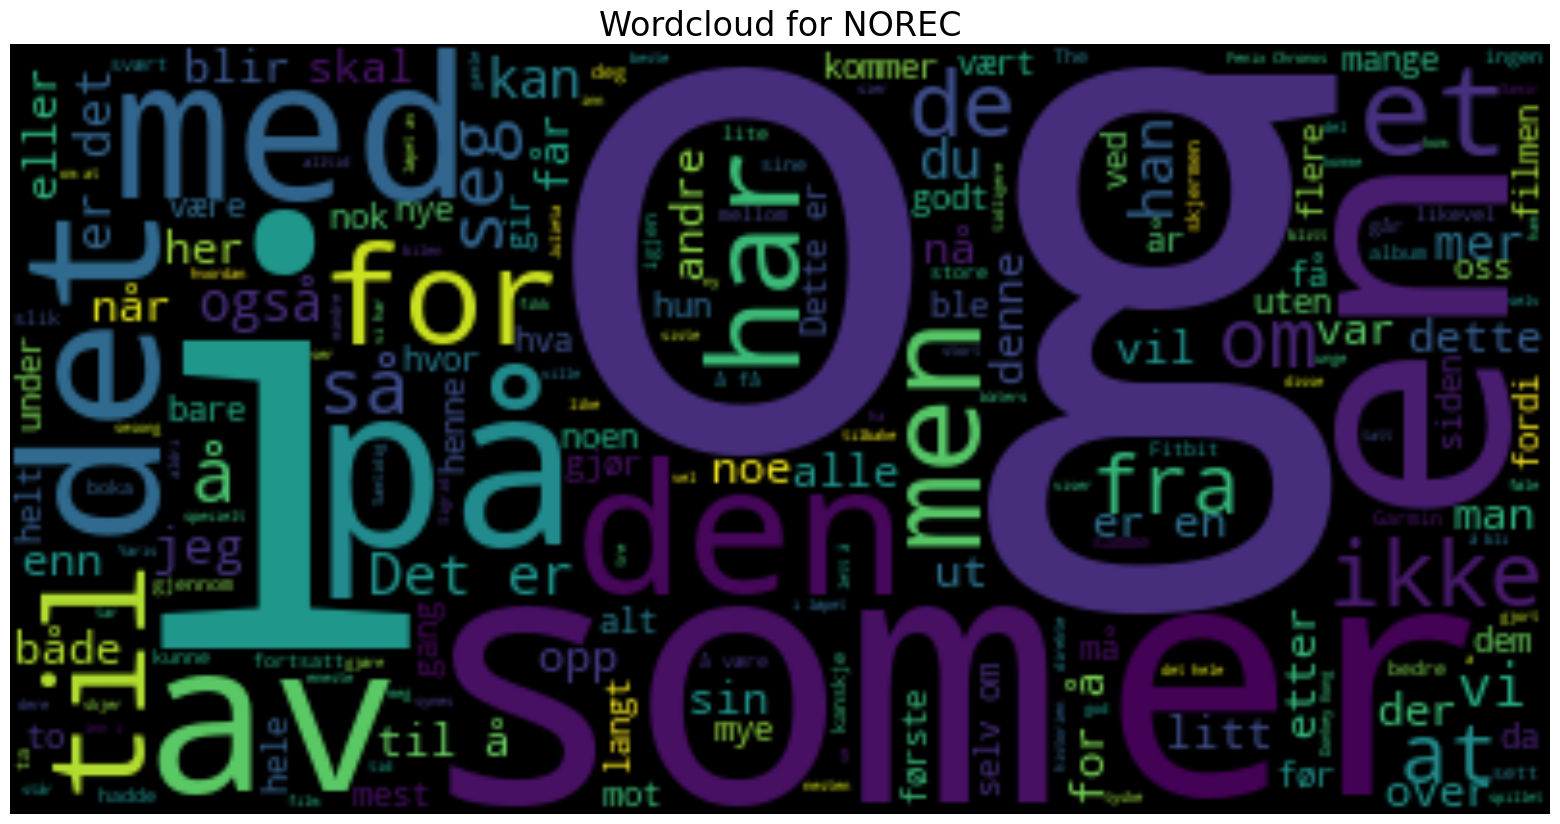

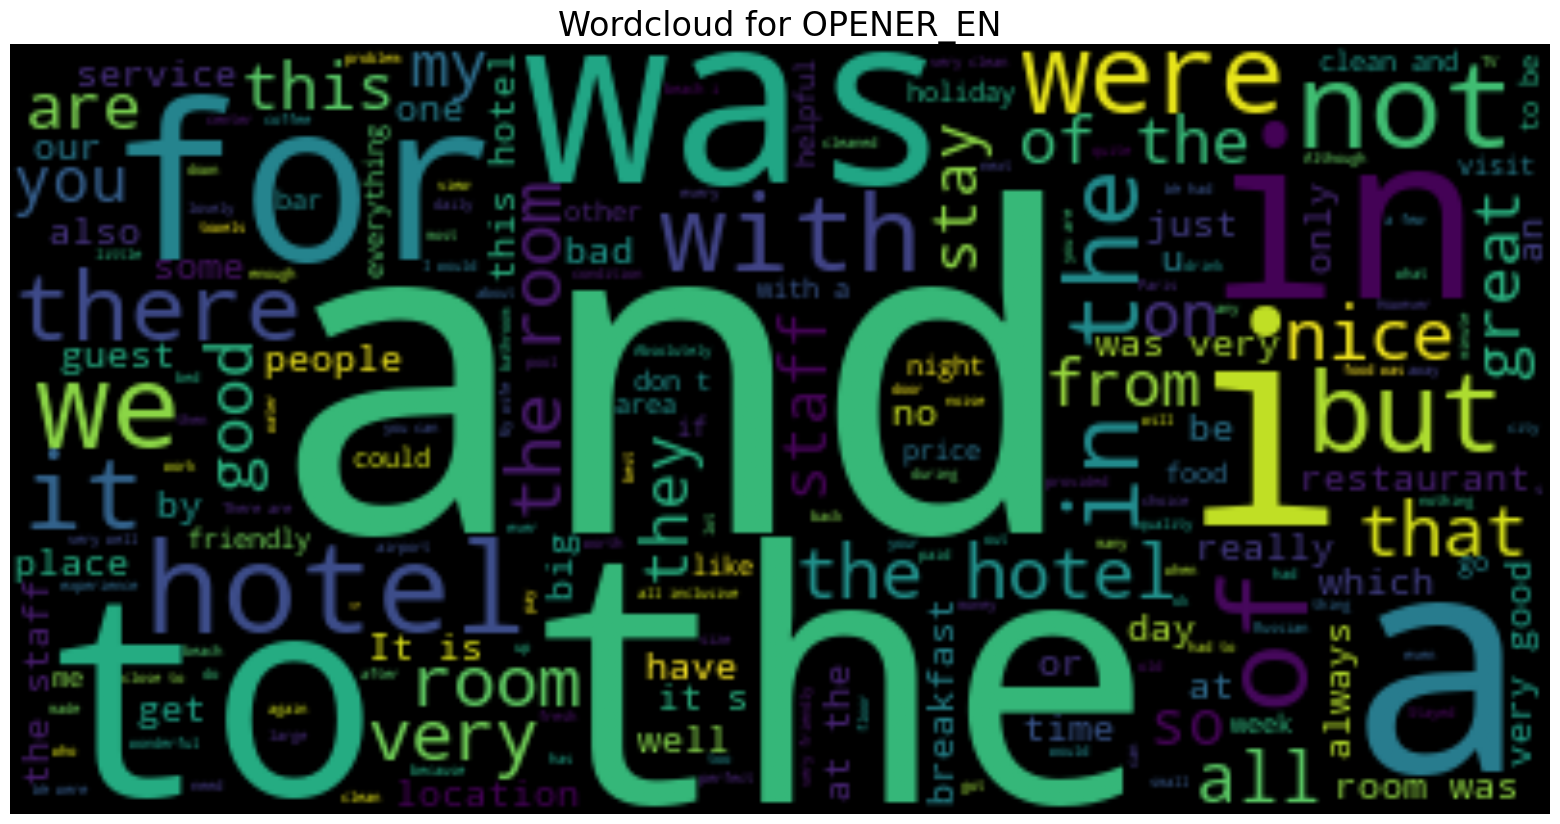

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from stopwordsiso import stopwords
import os
from utils import DatasetName, ApiUrl, InstructionType, ICLUsage, ExperimentType
from itertools import product
from wordcloud import WordCloud
from enum import Enum

base_path = os.path.join(
    "..",
    "..",
    "semeval22_structured_sentiment-master",
    "data",
)

datasets = {
    DatasetName.MPQA: None,
    DatasetName.NOREC: None,
    DatasetName.OPENER_EN: None,
}

combinations = product(
    [DatasetName.MPQA, DatasetName.NOREC, DatasetName.OPENER_EN],
    [ApiUrl.MISTRAL_7B_INSTRUCT],
    [InstructionType.STANDARD, InstructionType.CHAIN_OF_THOUGHT],
    [ICLUsage.ZERO_SHOT, ICLUsage.ONE_SHOT, ICLUsage.FEW_SHOT],
)

predictions = {
    DatasetName.MPQA: [],
    DatasetName.NOREC: [],
    DatasetName.OPENER_EN: [],
}

legends = ["Ground Truth"]
api_urls = {
    ApiUrl.MISTRAL_7B_INSTRUCT: "LLM",
}
instruction_types = {
    InstructionType.STANDARD: "Std",
    InstructionType.CHAIN_OF_THOUGHT: "CoT",
}
icl_usages = {
    ICLUsage.ZERO_SHOT: "zero-shot",
    ICLUsage.ONE_SHOT: "one-shot",
    ICLUsage.FEW_SHOT: "few-shot",
}

colors = ["gold", "blue", "green", "red", "purple", "brown"]

for dataset, api_url, instruction_type, icl_usage in combinations:
    prediction_path = os.path.join(
        "..",
        "predictions",
        ExperimentType.EXPERIMENT1.value,
        dataset.name,
        api_url.name,
        instruction_type.name,
        icl_usage.value,
        "predictions.json",
    )
    if not os.path.exists(prediction_path):
        continue
    prediction = pd.read_json(prediction_path)
    predictions[dataset].append(prediction)
    api_url = api_urls[api_url]
    instruction_type = instruction_types[instruction_type]
    icl_usage = icl_usages[icl_usage]
    legend = f"{api_url}-{instruction_type}-{icl_usage}"
    if legend not in legends:
        legends.append(legend)

for dataset in datasets:
    with open(os.path.join(base_path, dataset.value, "test.json")) as f:
        data = pd.read_json(f)
        datasets[dataset] = data
        file_path = os.path.join("..", "figures", "word-clouds", f"{dataset.value}.png")
        if not os.path.exists(file_path):
            wordcloud = WordCloud(stopwords=stopwords(dataset.value)).generate(
                " ".join(text for text in data["text"])
            )
            os.makedirs(os.path.dirname(file_path), exist_ok=True)
            wordcloud.to_file(file_path)
        else:
            wordcloud = plt.imread(file_path)
        plt.rcParams.update({"font.size": 20})
        plt.figure(figsize=(20, 10))
        plt.title(f"Wordcloud for {dataset.name}")
        plt.axis("off")
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.show()

# Set default font size and figure size of matplotlib
plt.rcParams.update({"font.size": 30})
default_fig_size = (20, 10)


## Exploring prportion of non-empty predictions in ground truth and LLM predictions

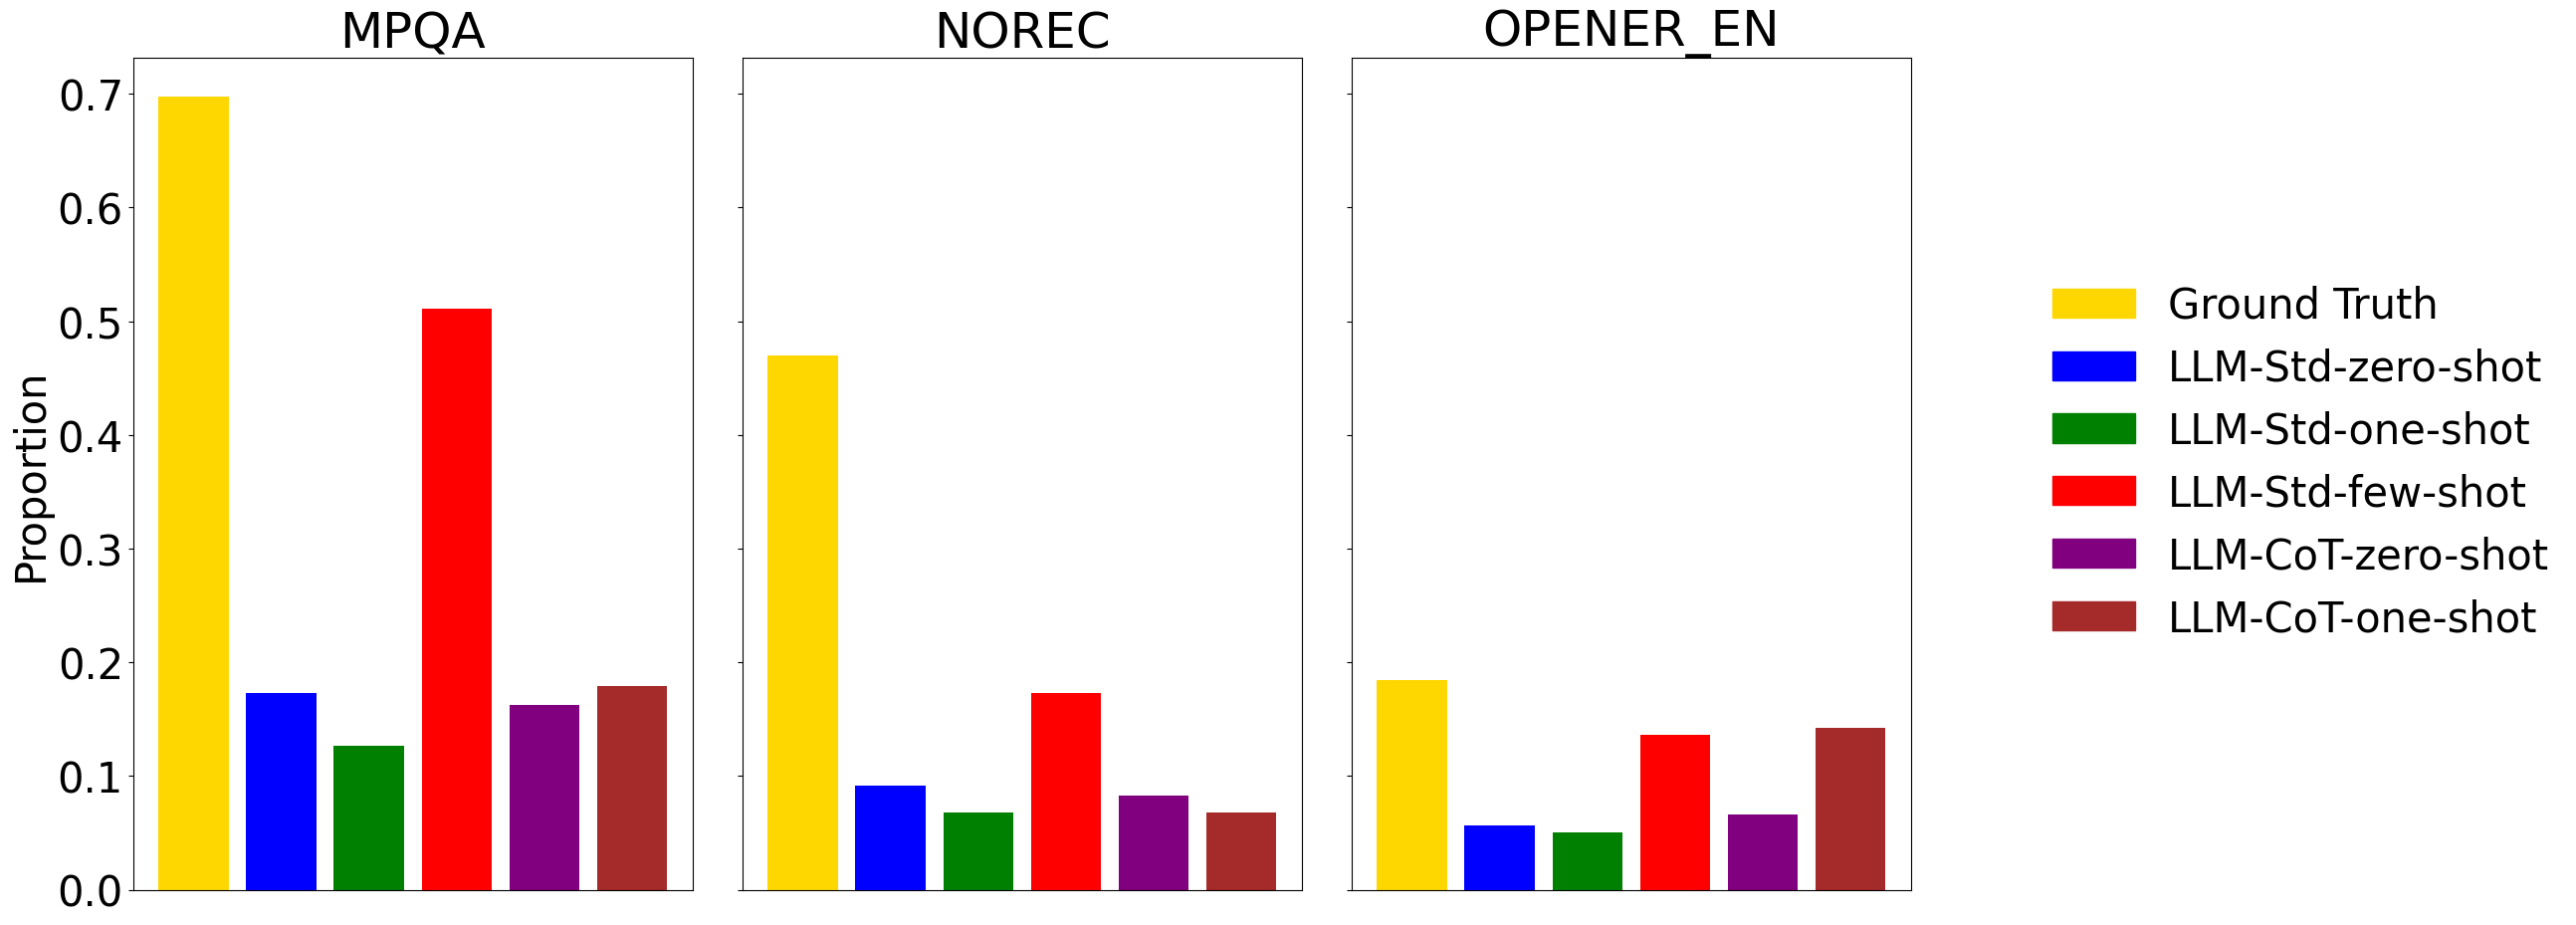

In [67]:
fig, axs = plt.subplots(
    1,
    len(datasets),
    figsize=default_fig_size,
    sharex=True,
    sharey=True,
)


def get_empty_opinion_proportions(data: pd.DataFrame):
    """Returns the proportion of texts with empty opinions."""
    return (
        data[data["opinions"].map(len) == 0].shape[0]
        / data.shape[0]
    )


for index, dataset in enumerate(datasets):
    non_empty_opinion_proportions = [
        get_empty_opinion_proportions(datasets[dataset]),
        *[
            get_empty_opinion_proportions(predictions)
            for predictions in predictions[dataset]
        ],
    ]
    color_map = dict(
        zip([index for (index, _) in enumerate(non_empty_opinion_proportions)], colors)
    )
    patches = [Patch(color=color, label=label) for (label, color) in color_map.items()]
    subplot = axs[index]
    subplot.set_title(dataset.name)
    subplot.bar(
        [index for (index, _) in enumerate(non_empty_opinion_proportions)],
        non_empty_opinion_proportions,
        color=colors,
    )
    subplot.get_xaxis().set_visible(False)
    if index == 0:
        subplot.set_ylabel("Proportion")


fig.legend(
    labels=legends,
    handles=patches,
    bbox_to_anchor=(1.04, 0.5),
    loc="center left",
    borderaxespad=0,
    frameon=False,
)
file_path = os.path.join("..", "figures", "empty-opions", "empty-opinions.png")
os.makedirs(os.path.dirname(file_path), exist_ok=True)
plt.tight_layout()
fig.savefig(file_path, bbox_inches="tight", dpi=100)
plt.show()

## Exploring the use of Source and Target spans in ground truth and LLM predictions

'Proportion of opinions with non-empty Source'

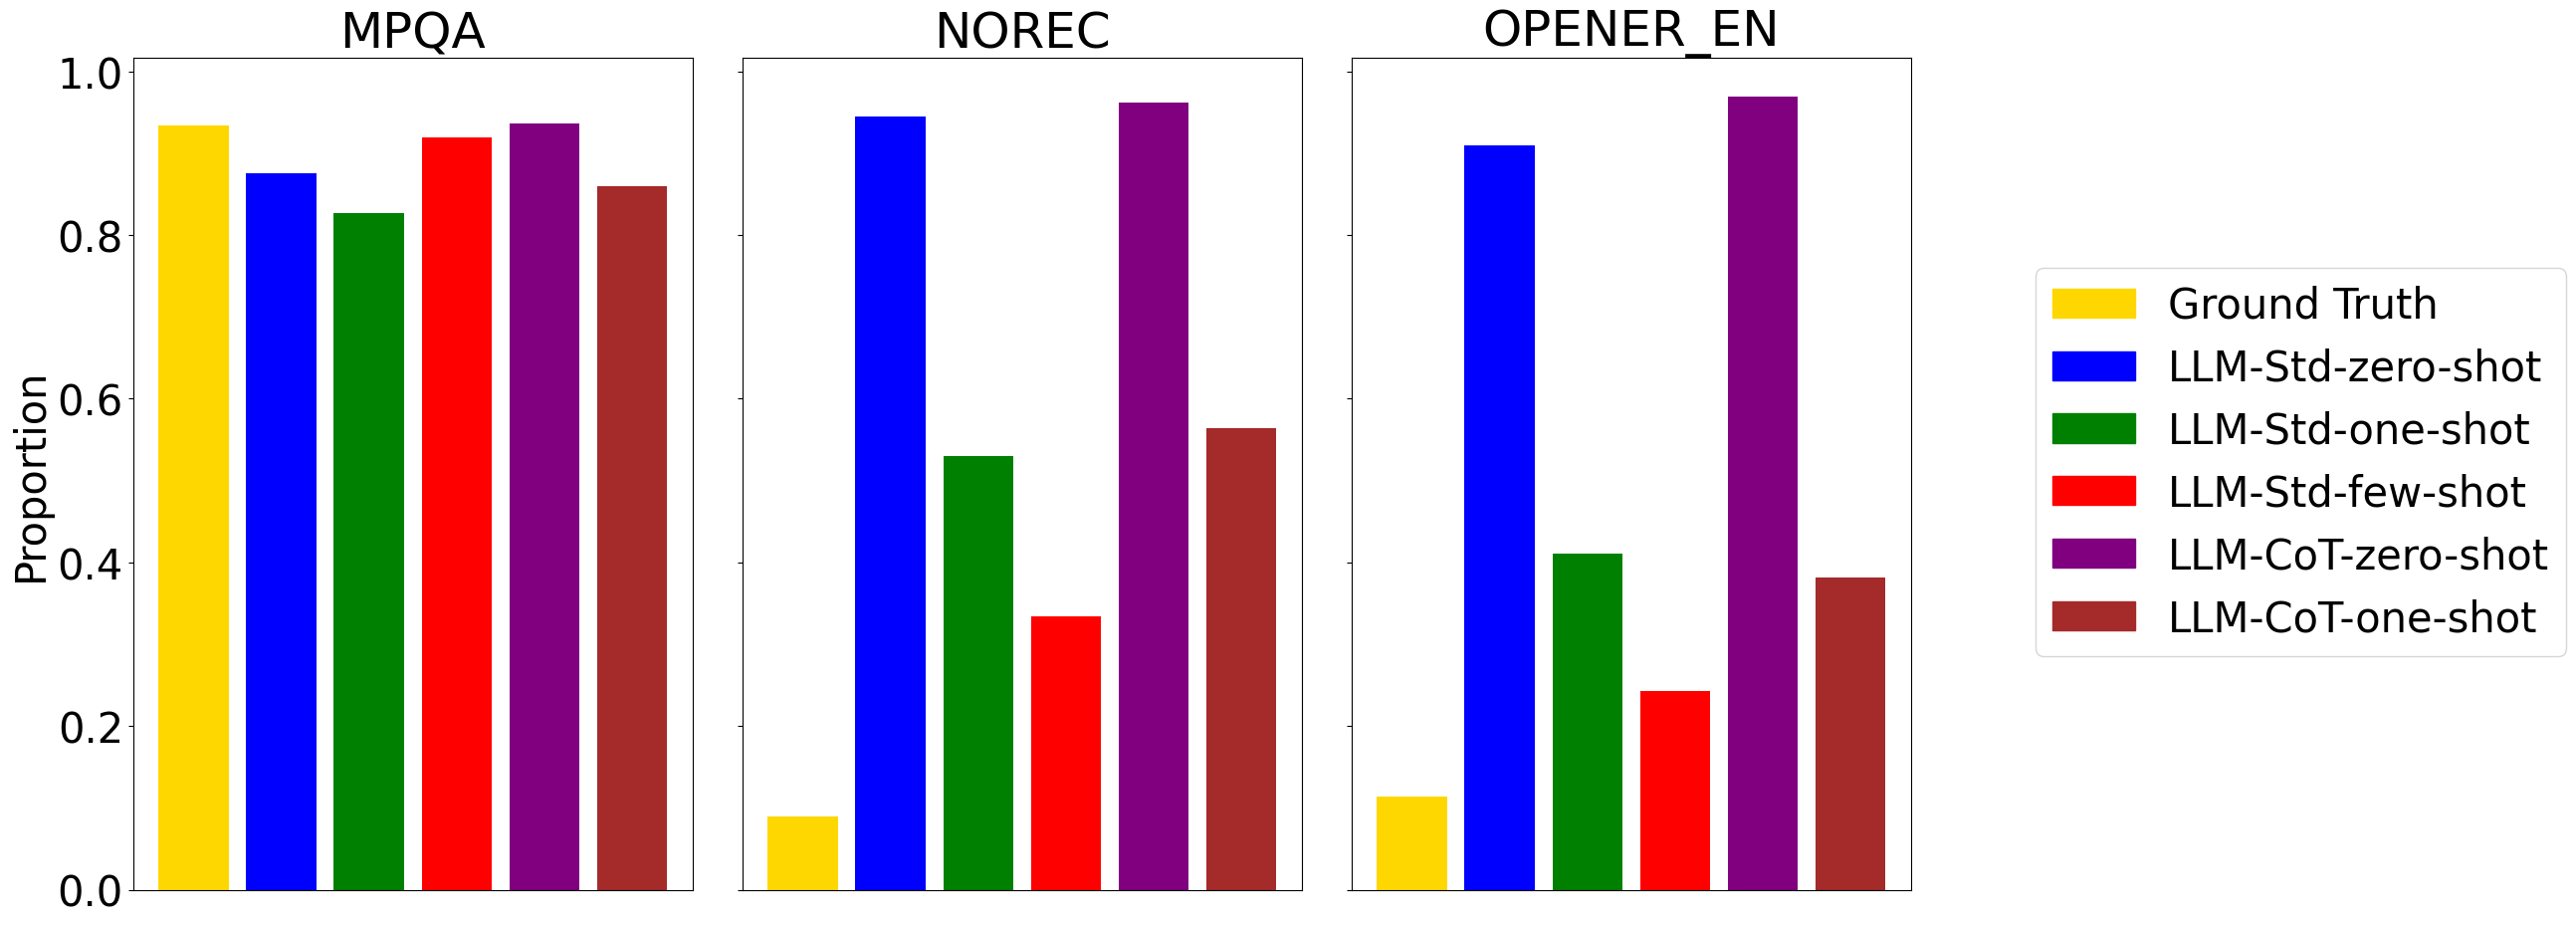

'Proportion of opinions with non-empty Target'

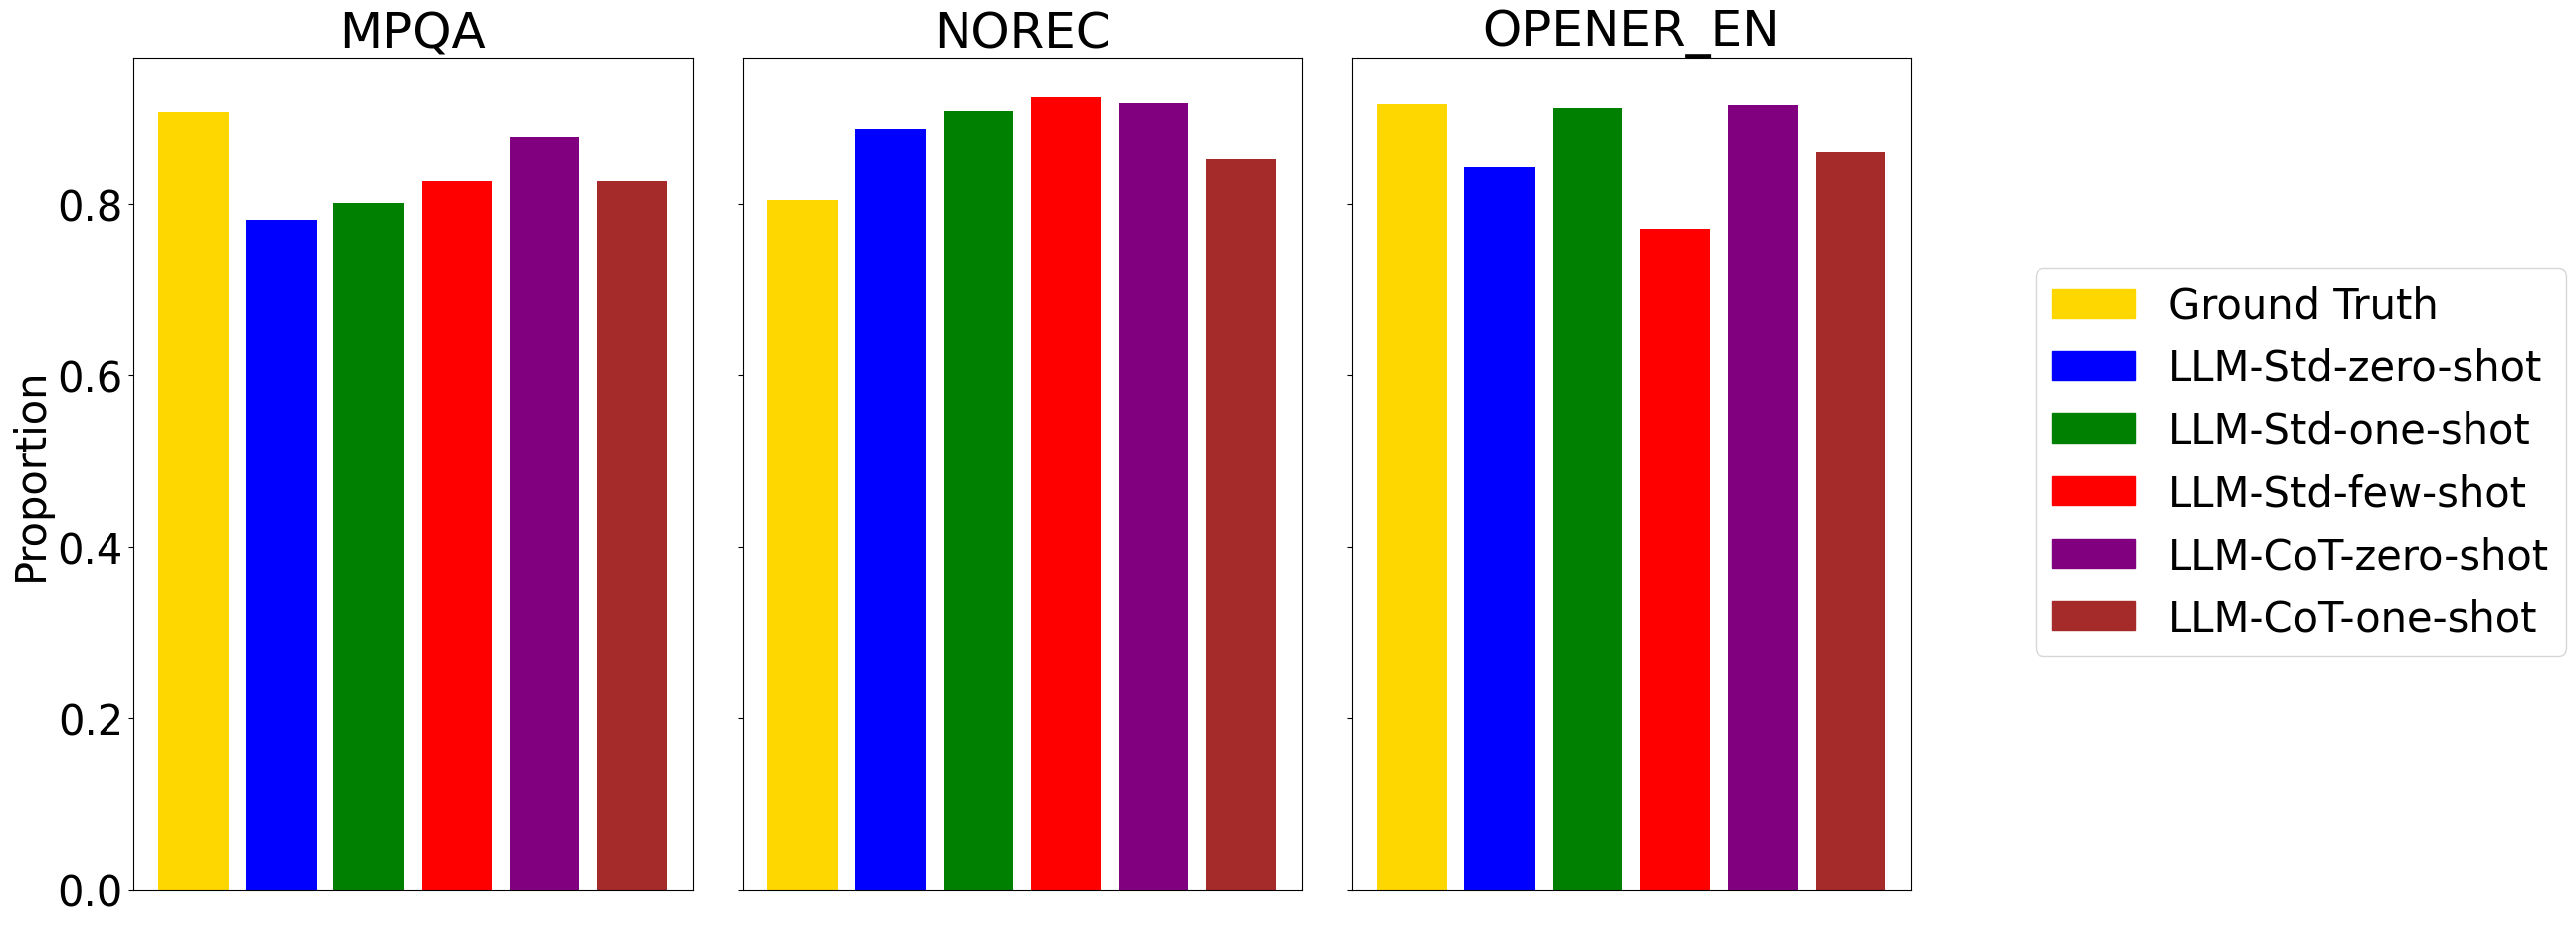

In [68]:
class SpanType(Enum):
    SOURCE = "Source"
    TARGET = "Target"


def get_span_proportion(dataset: pd.DataFrame, span_type: SpanType) -> float:
    """Returns the proportion of opinions containg a source span in the dataset."""
    all_opinions = [
        opinion
        for opinions in dataset["opinions"]
        for opinion in opinions
        if len(opinions) > 0
    ]
    opinions_with_source_span = [
        opinion for opinion in all_opinions if len(opinion[span_type.value][0]) > 0
    ]
    return len(opinions_with_source_span) / len(all_opinions)


for span_type in [SpanType.SOURCE, SpanType.TARGET]:
    fig, axs = plt.subplots(
        1, len(datasets), figsize=default_fig_size, sharex=True, sharey=True,
    )
    for index, dataset in enumerate(datasets):
        all_data = [
            datasets[dataset],
            *predictions[dataset],
        ]
        source_span_proportions = [
            get_span_proportion(data, span_type) for data in all_data
        ]
        color_map = dict(zip(source_span_proportions, colors))
        patches = [Patch(color=color, label=label) for (label, color) in color_map.items()]
        plt.title(
            f"Proportion of opinions with non-empty {span_type.value} in {dataset.name}"
        )
        x_ticks = [index for (index, _) in enumerate(legends)]
        subplot = axs[index]
        if index == 0:
            subplot.set_ylabel("Proportion")
        subplot.bar(
            [index for (index, _) in enumerate(legends)],
            source_span_proportions,
            color=colors,
        )
        subplot.get_xaxis().set_visible(False)
        subplot.title.set_text(dataset.name)
    file_path = os.path.join(
        "..", "figures", "span_proportions", f"{span_type.value}.png"
    )
    fig.legend(
        labels=legends,
        handles=patches,
        bbox_to_anchor=(1.04, 0.5),
        loc="center left",
        borderaxespad=0,
        frameon=True,
    )
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    plt.tight_layout()
    fig.savefig(file_path, bbox_inches="tight", dpi=100)
    display(f"Proportion of opinions with non-empty {span_type.value}")
    plt.show()

## Exploring proportions of Negative, Neutral, and Positive opinions in ground truth and LLM predictions

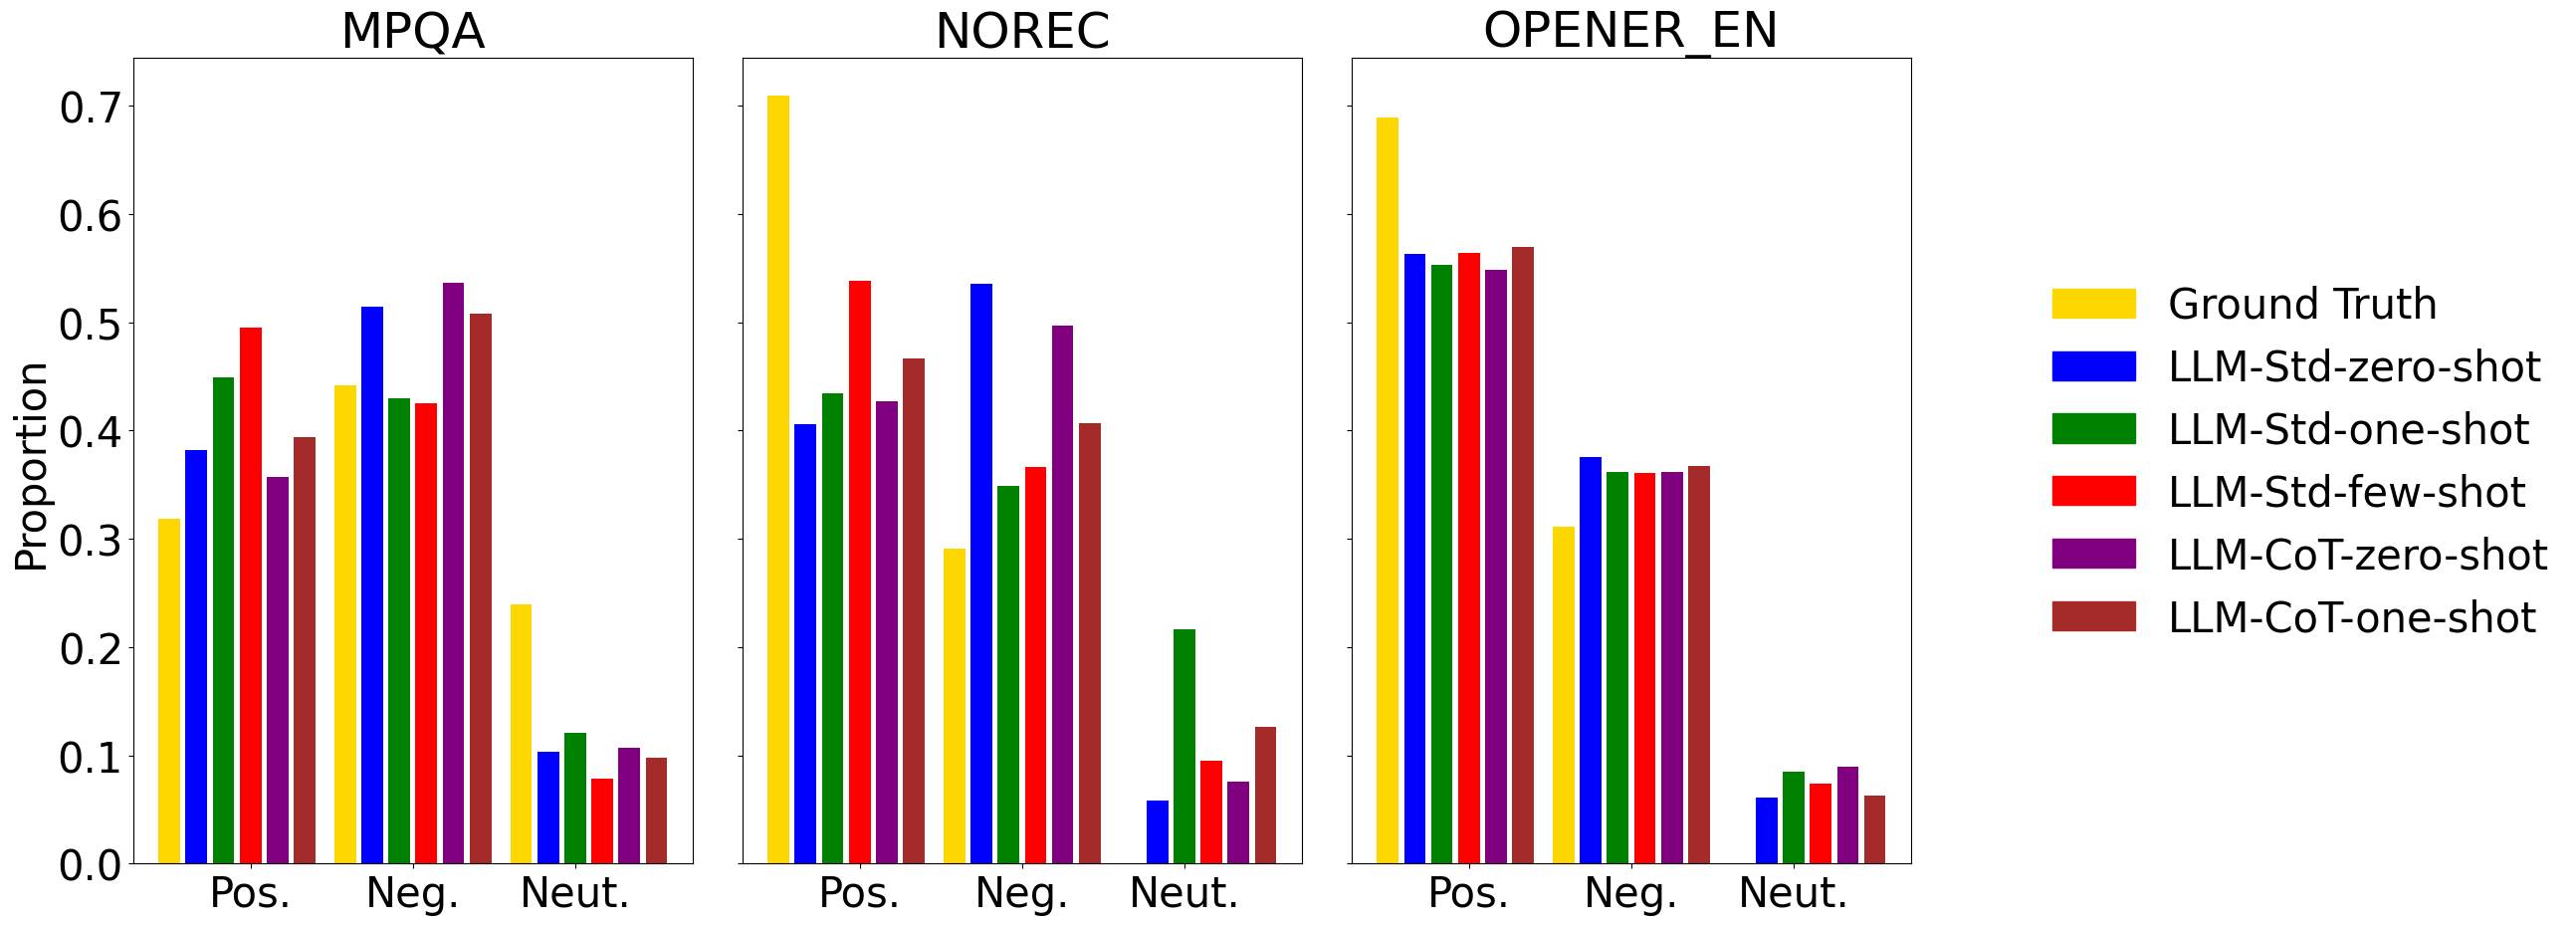

In [69]:
class Polarity(Enum):
    POSITIVE = "Positive"
    NEGATIVE = "Negative"
    NEUTRAL = "Neutral"

labels = {
    Polarity.POSITIVE: "Pos.",
    Polarity.NEGATIVE: "Neg.",
    Polarity.NEUTRAL: "Neut.",
} 

def get_polarity_proportions(dataset: pd.DataFrame) -> float:
    """Returns the proportion of opinions with the given polarity in the dataset."""
    all_opinions = [
        opinion
        for opinions in dataset["opinions"]
        for opinion in opinions
        if len(opinions) > 0
    ]
    proportions = []
    for polarity in Polarity:
        polarity_count = [
            opinion for opinion in all_opinions if opinion["Polarity"] == polarity.value
        ]
        proportions.append(len(polarity_count) / len(all_opinions))
    return proportions

fig, axs = plt.subplots(
    1, len(datasets), figsize=default_fig_size, sharex=False, sharey=True,
)
color_map = dict(zip(source_span_proportions, colors))
patches = [Patch(color=color, label=label) for (label, color) in color_map.items()]
fig.legend(
    labels=legends,
    handles=patches,
    bbox_to_anchor=(1.04, 0.5),
    loc="center left",
    borderaxespad=0,
    frameon=False,
)
for index, dataset in enumerate(datasets):
    all_data = [
        datasets[dataset],
        *predictions[dataset],
    ]
    all_proportions = [get_polarity_proportions(data) for data in all_data]
    non_empty_opinion_proportions = [
        proportion[index]
        for index in range(len(Polarity))
        for proportion in all_proportions
    ]
    subplot = axs[index]
    if index == 0:
        subplot.set_ylabel("Proportion")
    subplot.set_title(dataset.name)
    subplot.bar(
        [index + 0.5 * (index // len(all_data)) for (index, _) in enumerate(non_empty_opinion_proportions)],
        non_empty_opinion_proportions,
        color=colors,
    )
    # Group every 6th values together
    subplot.set_xticks(
        [index + len(all_data)//2 for (index, _) in enumerate(non_empty_opinion_proportions) if index % len(all_data) == 0],
        labels.values(),
    )
    # Add separation between groups
file_path = os.path.join("..", "figures", "polarity_proportions","polarity-proportions.png")
os.makedirs(os.path.dirname(file_path), exist_ok=True)
plt.tight_layout()
fig.savefig(file_path, bbox_inches="tight", dpi=100)
plt.show()